# Project Benson

## Aim

- High Gala Participation Rate

## How

- Identifying High Traffic Volumes at Subway Entrances/Exits
 - By Day of Week
 - By Hour of Day



- Identifying Target Audience (those more likely to be interested)
 - Identifying Stations with High Volumes of Non-Tourist Traffic (locals)
     - By comparing station's weekend vs weekday traffic

 - [Demographic & Geographic Profiles](https://datausa.io/profile/geo/new-york-ny)
     - Assume areas with more females more interested?
     - Assume areas with higher income more likely to donate?
     - Assume areas with younger demographics more interested?
     - Assume areas with higher education level more interested?
     - Assume areas with high employment in tech industry more interested?
  

## Importing Data for January - June 2019

In [1]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

## DO NOT RUN

In [ ]:
# 2017 Turnstile data from "https://data.ny.gov/Transportation/Turnstile-Usage-Data-2017/v5y5-mwpb"
# Replace the path below with your own
path = "/Users/kc/OneDrive/Projects/projectbenson/data/data_2017.csv"

df = pd.read_csv(path, sep=',')

In [ ]:
# Remove whitespace from column names
df.columns = df.columns.str.strip()

# Drop irrelevant columns
df.drop(columns=["Line Name", "Division", "Description"], axis=1, inplace=True)

In [ ]:
# Concatenate Date & Time into DateTime column DT
df["DT"] = df[['Date', 'Time']].apply(lambda x: ' '.join(x), axis=1)

# Convert DT into DateTime format
df["DT"] = pd.to_datetime(df["DT"], infer_datetime_format=True)

# Concatenate C/A, Unit & SCP into 1 Unique Identifier Column
df["ID"] = df[["C/A", "Unit", "SCP"]].apply(lambda x: ' '.join(x), axis=1)

In [ ]:
# Rearrange Columns
df = df[["ID", "DT", "Station", "Entries", "Exits"]]

# Drop rows before and after 2017
#df = df.loc[df["DT"].dt.year == 2017]
#df = df.loc[df["DT"].dt.month < 6]

In [ ]:
# Sort DT in descending order
df.sort_values(by=['ID', 'DT'], ascending=[True, False], inplace=True)

# Apply pd.Series.diff() on ["Entries"] and ["Exits"] within each ["ID"] group to obtain value of incremental change
df['Entry_Diff'] = df.groupby(['ID'])['Entries'].apply(lambda x: abs(x.diff()))
df['Exit_Diff'] = df.groupby(['ID'])['Exits'].apply(lambda x: abs(x.diff()))

# Sum values of incremental change for ["Entries"] and ["Exits"] for overall Traffic within time interval
df['Traffic'] = df["Entry_Diff"] + df["Exit_Diff"]

# test
# len(df.loc[df["ID"] == "A002 R051 02-00-00"])
# len(df.loc[df["ID"] == "A002 R051 02-00-01"])
# df.iloc[820:830]
# df.iloc[1640:1650]

In [ ]:
# Remove outliers

f1 = df["Entry_Diff"].quantile(0.99)
df = df[df["Entry_Diff"] < f1]

f2 = df["Exit_Diff"].quantile(0.99)
df = df[df["Exit_Diff"] < f2]

f3 = df["Traffic"].quantile(0.99)
df = df[df["Traffic"] < f3]


## END OF DO NOT RUN

In [2]:
# Pickle df so that above won't be necessary on each run
# with open('df.pickle', 'wb') as to_write:
#     pickle.dump(df, to_write)
    
# Open df.pickle & assign to df
with open('df.pickle','rb') as read_file:
    df = pickle.load(read_file)

df.head()

,ID,DT,Station,Entries,Exits,Entry_Diff,Exit_Diff,Traffic
1,A002 R051 02-00-00,2017-12-22 19:00:00,59 ST,6455505,2184926,282.0,51.0,333.0
2,A002 R051 02-00-00,2017-12-22 15:00:00,59 ST,6454819,2184867,686.0,59.0,745.0
3,A002 R051 02-00-00,2017-12-22 11:00:00,59 ST,6454437,2184773,382.0,94.0,476.0
4,A002 R051 02-00-00,2017-12-22 07:00:00,59 ST,6454285,2184501,152.0,272.0,424.0
5,A002 R051 02-00-00,2017-12-22 03:00:00,59 ST,6454273,2184470,12.0,31.0,43.0


#### Year

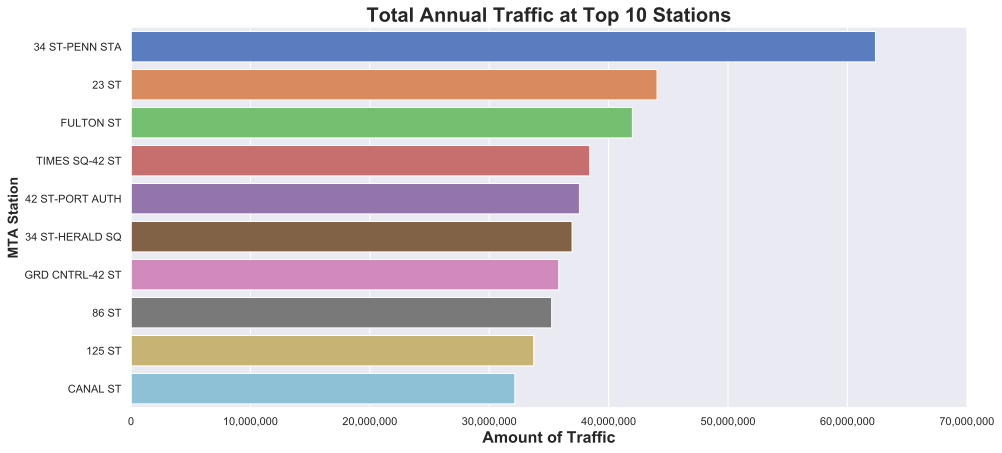

In [107]:
# Overall Top Monthly Station across all Stations
sns.set(rc={'figure.figsize':(15,7)})
yearly_sum_station = df.groupby(["Station"])["Traffic"].sum().sort_values(ascending=False)

#plt.style.use('ggplot')
sns.barplot(y=yearly_sum_station.head(10).index, x=yearly_sum_station.head(10), palette=("muted"), alpha=1)
sns.despine()

plt.title('Total Annual Traffic at Top 10 Stations', fontsize=20, fontweight='bold')
plt.xlabel('Amount of Traffic', fontsize=16, fontweight='bold')
plt.ylabel('MTA Station', fontsize=14, fontweight='bold')

ticks_x = np.linspace(0, 70000000, 8)
values_x = ['0','10,000,000', '20,000,000', '30,000,000', '40,000,000', '50,000,000', '60,000,000', '70,000,000']
plt.xticks(ticks_x, values_x);

plt.savefig('total_annual_traffic_top10_stations.svg')

In [4]:
# Top Station by Month
monthly_sum_station = df.groupby(["Station", df["DT"].dt.month])["Traffic"].sum().sort_values(ascending=False)

# Top 5 Stations & Their Busiest Months
df2 = monthly_sum_station.reset_index()
idx = df2.groupby(["Station"])["Traffic"].transform(max) == df2["Traffic"]
df2[idx].head(10)

### Kelsey pls plot
### This one for explaining October as busiest month & if deployment to these stations required,
### the months mentioned here will be the busiest in the year

,Station,DT,Traffic
0,34 ST-PENN STA,10,6345268.0
9,23 ST,5,4534258.0
11,FULTON ST,10,4374033.0
21,GRD CNTRL-42 ST,8,3997521.0
24,TIMES SQ-42 ST,10,3927521.0
26,42 ST-PORT AUTH,8,3852770.0
28,34 ST-HERALD SQ,8,3821568.0
42,86 ST,10,3572016.0
50,125 ST,10,3434653.0
60,CANAL ST,10,3323350.0


In [6]:
df2_34stpenn = df2.loc[df2["Station"] == "34 ST-PENN STA"]
df2_34stpenn = df2_34stpenn.sort_values('DT', ascending=True)

df2_23st = df2.loc[df2["Station"] == "23 ST"]
df2_23st = df2_23st.sort_values('DT', ascending=True)

df2_fultonst = df2.loc[df2["Station"] == "FULTON ST"]
df2_fultonst = df2_fultonst.sort_values('DT', ascending=True)

df2_gc42st = df2.loc[df2["Station"] == "GRD CNTRL-42 ST"]
df2_gc42st = df2_gc42st.sort_values('DT', ascending=True)

df2_ts42st = df2.loc[df2["Station"] == "TIMES SQ-42 ST"]
df2_ts42st = df2_ts42st.sort_values('DT', ascending=True)

''

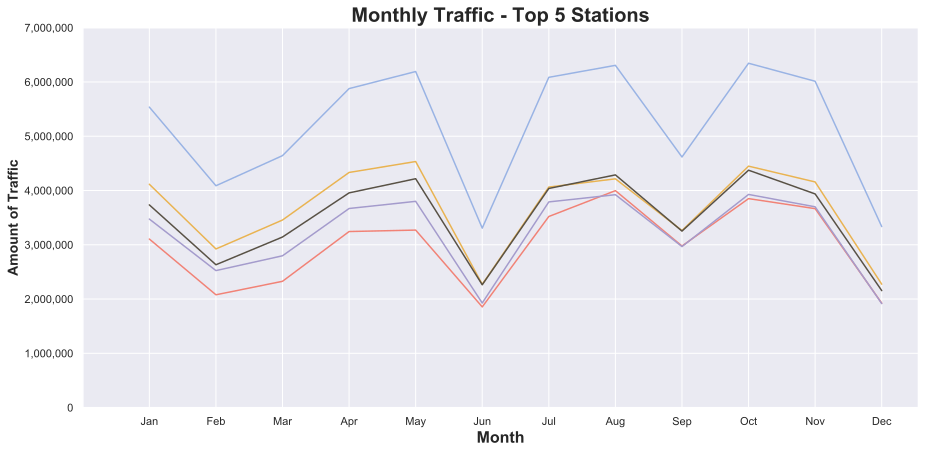

In [81]:
sns.despine()

sns.lineplot(x='DT', y='Traffic', data=df2_34stpenn, color='#99B3E4', alpha=1) #blue
sns.lineplot(x='DT', y='Traffic', data=df2_23st, color='#E9B351', alpha=1) #orange
sns.lineplot(x='DT', y='Traffic', data=df2_fultonst, color='#585145', alpha=1) #grey
sns.lineplot(x='DT', y='Traffic', data=df2_gc42st, color='#F18276', alpha=1) #red
sns.lineplot(x='DT', y='Traffic', data=df2_ts42st, color='#A49BCC', alpha=1) #purple

plt.title('Monthly Traffic - Top 5 Stations', fontsize=20, fontweight='bold')
plt.xlabel('Month', fontsize=16, fontweight='bold')
plt.ylabel('Amount of Traffic', fontsize=14, fontweight='bold')

ticks_x = np.linspace(0, 12, 13)
values_x = [' ','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks_x, values_x)

ticks_y = np.linspace(0, 7000000, 8)
values_y = ['0','1,000,000', '2,000,000', '3,000,000', '4,000,000', '5,000,000', '6,000,000', '7,000,000']
plt.yticks(ticks_y, values_y)


plt.savefig('monthly_traffic_top5.svg')
;

#### Daily

In [8]:
# Top Station by Day
daily_sum_station = df.groupby([df["DT"].dt.date, "Station"])["Traffic"].sum().sort_values(ascending=False)
daily_sum_station.head()

DT          Station       
2017-07-28  34 ST-PENN STA    249843.0
2017-10-20  34 ST-PENN STA    248981.0
2017-12-21  34 ST-PENN STA    248519.0
2017-04-26  34 ST-PENN STA    247727.0
2017-11-03  34 ST-PENN STA    246450.0
Name: Traffic, dtype: float64

#### Hour Interval

In [38]:
# Busiest Hour Interval by Station
hourly_sum_station = df.groupby([df["DT"].dt.hour, "Station"])["Traffic"].sum().sort_values(ascending=False)

# Busiest Hour Interval Across All Stations
hourly_sum = df.groupby([df["DT"].dt.hour])["Traffic"].sum().sort_values(ascending=False)
hourly_sum.head()

### Kelsey pls plot

DT
16    299781232.0
8     278030341.0
12    271254526.0
20    159923041.0
4     157014396.0
Name: Traffic, dtype: float64

''

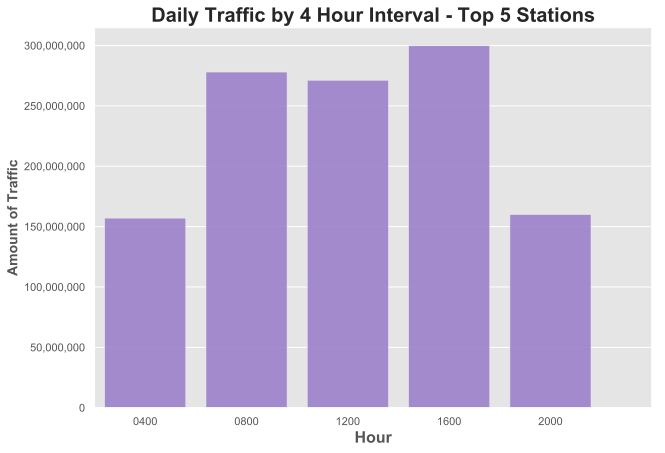

In [106]:
sns.set(rc={'figure.figsize':(10,7)})
plt.style.use('ggplot')
ax = sns.barplot(x=hourly_sum.head(5).index, y=hourly_sum.head(5),color='#966fd6', alpha=0.87)

plt.title('Daily Traffic by 4 Hour Interval - Top 5 Stations', fontsize=20, fontweight='bold')
plt.xlabel('Hour', fontsize=16, fontweight='bold')
plt.ylabel('Amount of Traffic', fontsize=14, fontweight='bold')

ticks_x = np.linspace(0, 5, 6)
values_x = ['0400','0800','1200','1600', '2000']
plt.xticks(ticks_x, values_x)

ticks_y = np.linspace(0, 300000000, 7)
values_y = ['0','50,000,000','100,000,000','150,000,000','200,000,000','250,000,000', '300,000,000']
plt.yticks(ticks_y, values_y)

plt.savefig('daily_traffic_4h_bar.svg')
;

In [15]:
df3 = hourly_sum_station.reset_index()
idx = df3.groupby(["Station"])["Traffic"].transform(max) == df3["Traffic"]
df3[idx].head(10)

,DT,Station,Traffic
0,16,34 ST-PENN STA,8787638.0
3,12,TIMES SQ-42 ST,6637051.0
4,12,23 ST,6270917.0
5,16,59 ST,6025317.0
6,12,34 ST-HERALD SQ,5973960.0
11,16,CHAMBERS ST,5366732.0
13,12,86 ST,5131599.0
17,17,FULTON ST,4945030.0
21,9,14 ST-UNION SQ,4699883.0
22,13,CANAL ST,4595436.0


In [16]:
df3_34stpenn = df3.loc[df3["Station"] == "34 ST-PENN STA"]
df3_34stpenn = df3_34stpenn.sort_values('DT', ascending=True)

df3_23st = df3.loc[df3["Station"] == "23 ST"]
df3_23st = df3_23st.sort_values('DT', ascending=True)

df3_fultonst = df3.loc[df3["Station"] == "FULTON ST"]
df3_fultonst = df3_fultonst.sort_values('DT', ascending=True)

df3_gc42st = df3.loc[df3["Station"] == "GRD CNTRL-42 ST"]
df3_gc42st = df3_gc42st.sort_values('DT', ascending=True)

df3_ts42st = df3.loc[df3["Station"] == "TIMES SQ-42 ST"]
df3_ts42st = df3_ts42st.sort_values('DT', ascending=True)

''

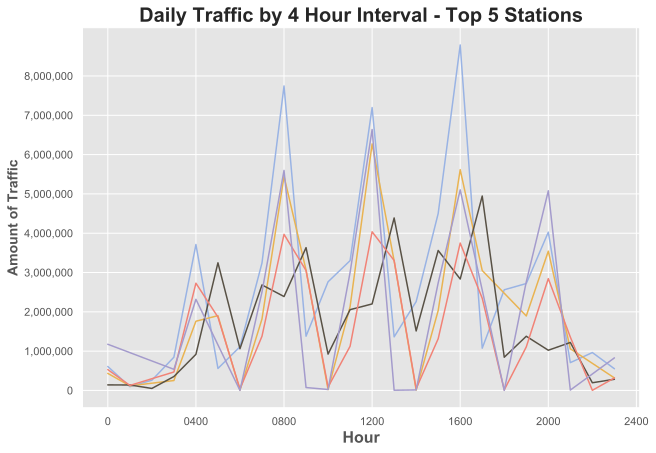

In [105]:
sns.despine()

sns.lineplot(x='DT', y='Traffic', data=df3_34stpenn, color='#99B3E4', alpha=1)
sns.lineplot(x='DT', y='Traffic', data=df3_23st, color='#E9B351', alpha=1)
sns.lineplot(x='DT', y='Traffic', data=df3_fultonst, color='#585145', alpha=1)
sns.lineplot(x='DT', y='Traffic', data=df3_gc42st, color='#F18276', alpha=1)
sns.lineplot(x='DT', y='Traffic', data=df3_ts42st, color='#A49BCC', alpha=1)

plt.title('Daily Traffic by 4 Hour Interval - Top 5 Stations', fontsize=20, fontweight='bold')
plt.xlabel('Hour', fontsize=16, fontweight='bold')
plt.ylabel('Amount of Traffic', fontsize=14, fontweight='bold')

ticks_x = np.linspace(0, 24, 7)
values_x = ['0','0400','0800','1200','1600', '2000', '2400']
plt.xticks(ticks_x, values_x)

ticks_y = np.linspace(0, 8000000, 9)
values_y = ['0','1,000,000', '2,000,000', '3,000,000', '4,000,000', '5,000,000', '6,000,000', '7,000,000','8,000,000']
plt.yticks(ticks_y, values_y)


plt.savefig('daily_traffic_4h_line.svg')
;

### Week

In [18]:
# Busiest Day by Station
dow_sum_station = df.groupby([df["DT"].dt.dayofweek, "Station"])["Traffic"].sum().sort_values(ascending=False)
dow_sum_station.head(20)

DT  Station        
4   34 ST-PENN STA     10162644.0
2   34 ST-PENN STA     10075228.0
3   34 ST-PENN STA      9962784.0
1   34 ST-PENN STA      9573242.0
0   34 ST-PENN STA      9434388.0
2   23 ST               7564958.0
3   23 ST               7476714.0
    FULTON ST           7473796.0
2   FULTON ST           7464335.0
4   FULTON ST           7350434.0
1   23 ST               7300516.0
    FULTON ST           7241644.0
4   23 ST               7106981.0
5   34 ST-PENN STA      7104829.0
0   23 ST               6950218.0
    FULTON ST           6878909.0
6   34 ST-PENN STA      6036430.0
2   TIMES SQ-42 ST      5936427.0
3   TIMES SQ-42 ST      5932217.0
4   42 ST-PORT AUTH     5869061.0
Name: Traffic, dtype: float64

In [19]:
df4 = dow_sum_station.reset_index()
idx = df4.groupby(["Station"])["Traffic"].transform(max) == df4["Traffic"]
df4[idx].head(10)

,DT,Station,Traffic
0,4,34 ST-PENN STA,10162644.0
5,2,23 ST,7564958.0
7,3,FULTON ST,7473796.0
17,2,TIMES SQ-42 ST,5936427.0
19,4,42 ST-PORT AUTH,5869061.0
21,2,GRD CNTRL-42 ST,5829831.0
26,2,86 ST,5704526.0
30,4,34 ST-HERALD SQ,5634120.0
40,2,59 ST,5355029.0
43,2,125 ST,5330417.0


In [20]:
df4_34stpenn = df4.loc[df4["Station"] == "34 ST-PENN STA"]
df4_34stpenn = df4_34stpenn.sort_values('DT', ascending=True)

df4_23st = df4.loc[df4["Station"] == "23 ST"]
df34_23st = df4_23st.sort_values('DT', ascending=True)

df4_fultonst = df4.loc[df4["Station"] == "FULTON ST"]
df4_fultonst = df4_fultonst.sort_values('DT', ascending=True)

df4_gc42st = df4.loc[df4["Station"] == "GRD CNTRL-42 ST"]
df4_gc42st = df4_gc42st.sort_values('DT', ascending=True)

df4_ts42st = df4.loc[df4["Station"] == "TIMES SQ-42 ST"]
df4_ts42st = df4_ts42st.sort_values('DT', ascending=True)

''

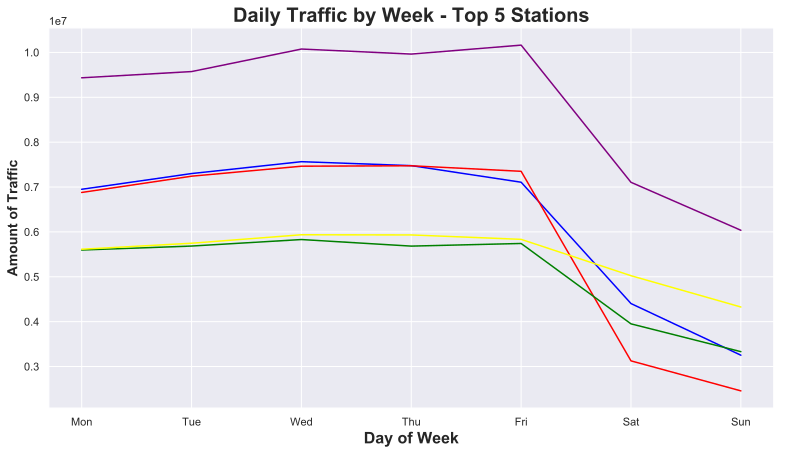

In [69]:
sns.despine()

sns.lineplot(x='DT', y='Traffic', data=df4_34stpenn, color='purple', alpha=1)
sns.lineplot(x='DT', y='Traffic', data=df4_23st, color='blue', alpha=1)
sns.lineplot(x='DT', y='Traffic', data=df4_fultonst, color='red', alpha=1)
sns.lineplot(x='DT', y='Traffic', data=df4_gc42st, color='green', alpha=1)
sns.lineplot(x='DT', y='Traffic', data=df4_ts42st, color='yellow', alpha=1)

plt.title('Daily Traffic by Week - Top 5 Stations', fontsize=20, fontweight='bold')
plt.xlabel('Day of Week', fontsize=16, fontweight='bold')
plt.ylabel('Amount of Traffic', fontsize=14, fontweight='bold')

ticks_x = (0,1,2,3,4,5,6)
#np.linspace(0, 7, 8)
values_x = ['Mon','Tue','Wed','Thu','Fri', 'Sat', 'Sun']
plt.xticks(ticks_x, values_x)

#ticks_y = np.linspace(0, 11000000, 10)
#values_y = ['0','3,000,000', '4,000,000', '5,000,000', '6,000,000', '7,000,000', '8,000,000', '9,000,000','10,000,000','11,000,000']
#plt.yticks(ticks_y, values_y)
;

#plt.savefig('dow_traffic_at_34penn.svg')

In [22]:
# Busiest Day Across Stations
# 0 is Monday
dow_sum_all = df.groupby([df["DT"].dt.dayofweek])["Traffic"].sum().sort_values(ascending=False)
dow_sum_all.head(20)

### Kelsey pls plot

DT
2    394460034.0
3    390675845.0
4    385017309.0
1    379881284.0
0    366473768.0
5    254737907.0
6    207678698.0
Name: Traffic, dtype: float64

''

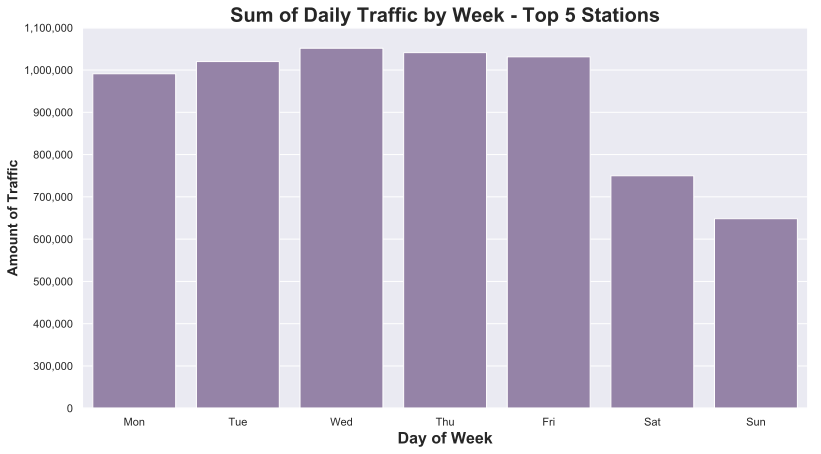

In [68]:
sns.set(rc={'figure.figsize':(13,7)})

sns.despine()

sns.barplot(x='DT', y='Traffic', data=df4, color='#957DAD', alpha=1, ci=None)

plt.title('Sum of Daily Traffic by Week - Top 5 Stations', fontsize=20, fontweight='bold')
plt.xlabel('Day of Week', fontsize=16, fontweight='bold')
plt.ylabel('Amount of Traffic', fontsize=14, fontweight='bold')

ticks_x = (0,1,2,3,4,5,6)
#np.linspace(0, 7, 8)
values_x = ['Mon','Tue','Wed','Thu','Fri', 'Sat', 'Sun']
plt.xticks(ticks_x, values_x)

ticks_y = np.linspace(0, 1100000, 10)
values_y = ['0','300,000', '400,000', '500,000', '600,000', '700,000', '800,000', '900,000','1,000,000','1,100,000']
plt.yticks(ticks_y, values_y)

plt.savefig('sum_daily_traffic_top5.svg')

;